In [143]:
import numpy as np
import matplotlib
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

In [201]:
possible_actions = ['hit', 'stick'] # possible actions - hit or stick
# current sum (12-21), dealers one car (ace-10) and whether he holds a usable ace
num_trials = 1000

class Black_Jack_Game():
    def __init__(self, current_player_sum=None, dealer_visible_card=None, holds_usable_ace=None, exploring_starts=False, dealer_sum=None, dealer_usable_ace=None, dealer_other_card=None, first_action=None):
        
        self.exploring_starts = exploring_starts
        
        if (exploring_starts == False):
            self.current_player_sum = current_player_sum
            self.dealer_visible_card = dealer_visible_card
            self.holds_usable_ace = holds_usable_ace
            self.current_player_sum, self.dealer_visible_card, self.holds_usable_ace = self.initiate()
            self.dealer_sum = dealer_visible_card
            self.dealer_usable_ace = False
            self.dealer_other_card = 0
            self.first_action = None
            
        else:
            sum_player = np.random.randint(11, 22)
            usable_ace_player_ = np.random.randint(0, 2)
            if (usable_ace_player_ == 0):
                usable_ace_player = False
            else:
                usable_ace_player = True
            faceup_card = np.random.randint(1, 11)
            random_action = np.random.choice(possible_actions)
            
            ace, next_card_dealer = self.hit()
            dealer_sum_1 = 0
            usable_ace = False
            
            if (faceup_card == 1 and ace == True):
                dealer_sum_1 = 12
                usable_ace = True
            elif (ace == True):
                dealer_sum_1 = faceup_card + 11
                usable_ace = True
            elif (faceup_card == 1):
                dealer_sum_1 = next_card_dealer + 11
                usable_ace = True
            else:
                dealer_sum_1 = faceup_card + next_card_dealer
                
            self.current_player_sum = sum_player
            self.dealer_visible_card = faceup_card
            self.holds_usable_ace = usable_ace_player
            self.dealer_sum = dealer_sum_1
            self.dealer_usable_ace = usable_ace
            self.dealer_other_card = next_card_dealer
            self.first_action = random_action
            
    def check_burst(self):
        if (self.current_player_sum > 21):
            return True
        else:
            return False
    
    def hit(self):
        card = (np.random.randint(1, 14))
        ace = False
        card_sum = 0
        if (card == 11 or card == 12 or card == 13):
            card_sum = 10
        elif (card == 1):
            ace = True
            card_sum = card
        else:
            card_sum = card
        return ace, card_sum
    
    def initiate(self):
        
        # setting up the player's initial cards
        self.current_player_sum = 0
        self.holds_usable_ace = False
        
        while(self.current_player_sum < 12):
            is_ace, card_received = self.hit()
                        
            if (is_ace == True):
                if (self.current_player_sum + 11 <= 21):
                    self.current_player_sum += 11
                    self.holds_usable_ace = True
                elif (self.holds_usable_ace):
                    self.current_player_sum += 1
                
            elif (is_ace == False):
                self.current_player_sum += card_received
               
            if (self.current_player_sum > 21):
                if (self.holds_usable_ace):
                    self.current_player_sum -= 10
                    self.holds_usable_ace = False
                
        # setting up dealer's face up card
        dealer_is_ace, dealer_card = self.hit()
        self.dealer_visible_card = dealer_card
        
        return self.current_player_sum, self.dealer_visible_card, self.holds_usable_ace
    
def choose_hit_or_stick(player_sum):
    if (player_sum == 20 or player_sum == 21):
        return 'stick'
    else:
        return 'hit'
    
def choose_hit_or_stick_dealer(player_sum):
    if (player_sum < 17):
        return 'hit'
    else:
        return 'stick'

In [267]:
# follow the current updated policy rather than a fixed policy
def follow_policy(policy, i, j, k):
    if (k == True):
        k_ = 1
    else:
        k_ = 0
    if (policy[i-12, j-1, k_] == 1):
        return 'hit'
    else:
        return 'stick'

def play_Black_Jack(game, behavioural=False, current_policy=None):
    player_sum, dealer_faceup_card, ace_usable = game.current_player_sum, game.dealer_visible_card, game.holds_usable_ace
    reward_received = 0
    
    collection = []  
    if (game.exploring_starts == False):
        if (behavioural == True):
            action = np.random.choice(possible_actions)
        else:
            action = choose_hit_or_stick(player_sum)
    else:
        action = np.random.choice(possible_actions)
        
    while (True):
        player_state = np.asarray([player_sum, dealer_faceup_card, ace_usable])
        collection.append([player_state, action])
        
        # player's turn
        
        if (action == 'hit'):
            # hits if sum < 20
            ace, card_sum = game.hit()
            
            if (ace == True and ace_usable == True):
                player_sum += 1
            elif (ace == True and ace_usable == False):
                ace_usable = True
                player_sum += 11
            elif (ace == False):
                player_sum += card_sum
                
            if (player_sum > 21):
                if (ace_usable == True):
                    player_sum -= 10
                    ace_usable = False
                    if (player_sum > 21):
                        reward_received = -1
                        return collection, reward_received
                else:
                    reward_received = -1
                    return collection, reward_received

        elif (action == 'stick'):
            # sticks if sum is 20 or 21
            # moves to dealer's turn
            break
            
        if (game.exploring_starts == True): # part 2 
            action = follow_policy(current_policy, player_sum, dealer_faceup_card, ace_usable)
        else:
            if (behavioural == False): # part 1
                action = choose_hit_or_stick(player_sum)
            else: # part 3
                action = np.random.choice(possible_actions)
        
    if (game.exploring_starts == False):
        dealer_sum = dealer_faceup_card
        dealer_ace = False
    else:
        dealer_sum = game.dealer_sum
        dealer_ace = game.dealer_usable_ace
    action_dealer = choose_hit_or_stick_dealer(dealer_sum)
    
    # dealer's turn
    while (True):
        if (action_dealer == 'hit'):
            ace, card_sum = game.hit()
            if (ace == True and dealer_ace == False):
                dealer_ace = True
                dealer_sum += 11
            elif (ace == True and dealer_ace == True):
                player_sum += 1
            elif (ace == False):
                dealer_sum += card_sum
                
            # burst
            if (dealer_sum > 21):
                if (dealer_ace == True):
                    dealer_sum -= 10
                    dealer_ace = False
                else:
                    # no aces
                    reward_received = 1
                    return collection, reward_received
        
        elif (action_dealer == 'stick'):
            break
            
        action_dealer = choose_hit_or_stick_dealer(dealer_sum)
        
    # checking sum of both to decide the winner
    if (player_sum > dealer_sum):
        reward_received = 1
    elif (player_sum < dealer_sum):
        reward_received = -1
    else:
        reward_received = 0
    return collection, reward_received

In [98]:
def monte_carlo_every_visit(num_episode):
    v_pi = np.zeros((10, 10, 2)) # dealer, current sum, usable ace
    usable_ace = np.ones((10, 10, 2))   
    
    for i in range(num_episode):
        g = 0
        game = Black_Jack_Game()
        collection, reward = play_Black_Jack(game)
        for j in range(len(collection) - 1, -1, -1):
            state, _ = collection[j]
            usable = 1
            if (not state[2]):
                usable = 0
            v_pi[state[1] - 1, state[0] - 12, usable] += reward
            usable_ace[state[1] - 1, state[0] - 12, usable] += 1      
    v_pi = v_pi / usable_ace
    
    return v_pi

[[-0.6 -0.2  0.  -0.2 -0.2 -0.1 -0.4 -0.2  0.4  0.7]
 [-0.5 -0.8 -0.6 -0.5 -0.3 -0.4 -0.9 -0.5  0.6  0.8]
 [-0.1 -0.3 -0.3 -0.2 -0.3 -0.2 -0.5 -0.1  0.3  0.8]
 [ 0.  -0.1 -0.2 -0.7 -0.6 -0.5 -0.1 -0.1  0.4  0.9]
 [-0.9 -0.3 -0.5 -0.6 -0.6 -0.4 -0.5 -0.6  0.5  0.9]
 [-0.3 -0.7 -0.1  0.4  0.1 -0.4 -0.4 -0.6  0.8  0.9]
 [-0.2 -0.2 -0.4 -0.2  0.1 -0.1 -0.6 -0.5  0.5  0.9]
 [ 0.2  0.4 -0.3 -0.2  0.1 -0.2  0.1 -0.1  0.7  1. ]
 [-0.2  0.  -0.1 -0.4 -0.5 -0.4 -0.5 -0.4  0.8  1. ]
 [-0.4 -0.4 -0.2 -0.2 -0.2 -0.2 -0.4 -0.6  0.3  0.8]]
[[-0.6 -0.7 -0.7 -0.6 -0.7 -0.7 -0.7 -0.6  0.5  0.9]
 [-0.5 -0.4 -0.6 -0.7 -0.7 -0.8 -0.9 -0.8  0.6  0.8]
 [-0.6 -0.6 -0.6 -0.6 -0.7 -0.6 -0.7 -0.6  0.7  0.9]
 [-0.7 -0.6 -0.6 -0.7 -0.7 -0.6 -0.7 -0.7  0.7  0.9]
 [-0.6 -0.5 -0.7 -0.7 -0.5 -0.8 -0.8 -0.8  0.7  0.9]
 [-0.5 -0.5 -0.7 -0.7 -0.8 -0.8 -0.7 -0.8  0.7  0.9]
 [-0.4 -0.5 -0.5 -0.6 -0.6 -0.7 -0.6 -0.7  0.8  1. ]
 [-0.6 -0.6 -0.7 -0.6 -0.8 -0.7 -0.6 -0.6  0.7  0.9]
 [-0.5 -0.4 -0.7 -0.7 -0.6 -0.6 -0.8 -0.8  0.

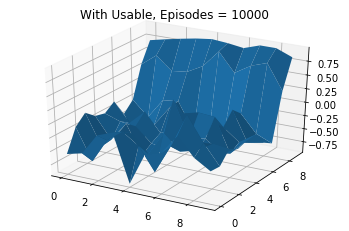

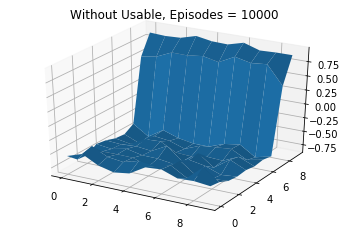

[[-0.3 -0.2 -0.3 -0.3 -0.4 -0.4 -0.5 -0.5  0.5  0.8]
 [-0.3 -0.2 -0.3 -0.3 -0.4 -0.4 -0.4 -0.4  0.6  0.9]
 [-0.2 -0.2 -0.2 -0.3 -0.4 -0.4 -0.4 -0.4  0.6  0.9]
 [-0.3 -0.3 -0.2 -0.3 -0.4 -0.4 -0.4 -0.5  0.6  0.9]
 [-0.2 -0.3 -0.3 -0.3 -0.3 -0.4 -0.4 -0.5  0.7  0.9]
 [-0.2 -0.3 -0.3 -0.3 -0.4 -0.4 -0.4 -0.4  0.7  0.9]
 [-0.2 -0.2 -0.2 -0.3 -0.3 -0.3 -0.3 -0.4  0.8  0.9]
 [-0.2 -0.2 -0.3 -0.3 -0.3 -0.4 -0.3 -0.4  0.8  0.9]
 [-0.1 -0.3 -0.3 -0.3 -0.3 -0.4 -0.4 -0.4  0.7  0.9]
 [-0.3 -0.3 -0.3 -0.4 -0.4 -0.4 -0.5 -0.5  0.4  0.9]]
[[-0.6 -0.6 -0.6 -0.6 -0.7 -0.7 -0.7 -0.7  0.5  0.8]
 [-0.5 -0.6 -0.6 -0.6 -0.7 -0.7 -0.7 -0.7  0.6  0.9]
 [-0.6 -0.6 -0.6 -0.6 -0.7 -0.7 -0.7 -0.7  0.7  0.9]
 [-0.5 -0.6 -0.6 -0.6 -0.7 -0.7 -0.7 -0.7  0.7  0.9]
 [-0.6 -0.6 -0.6 -0.6 -0.6 -0.7 -0.7 -0.7  0.7  0.9]
 [-0.5 -0.6 -0.6 -0.6 -0.7 -0.7 -0.7 -0.7  0.7  0.9]
 [-0.5 -0.5 -0.6 -0.6 -0.6 -0.7 -0.7 -0.7  0.8  0.9]
 [-0.5 -0.6 -0.6 -0.6 -0.6 -0.7 -0.7 -0.7  0.8  0.9]
 [-0.5 -0.6 -0.6 -0.6 -0.7 -0.7 -0.7 -0.7  0.

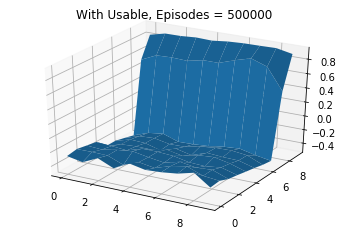

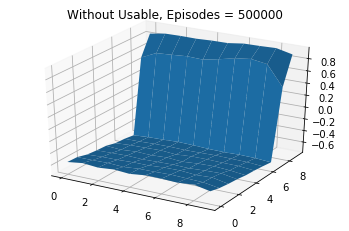

In [101]:
def fun(matrix, i, j):
    return matrix[i, j]

def plot_value_func(num_episode):
    
    v_pi = monte_carlo_every_visit(num_episode)
    without_usable = v_pi[:, :, 0]
    with_usable = v_pi[:, :, 1]
    
    print (np.round(with_usable, 1))
    print (np.round(without_usable, 1))
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(0, 10, 1)
    X, Y = np.meshgrid(x, y)
    zs = np.array(fun(with_usable, X, Y))
    Z = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z)
    plt.title('With Usable, Episodes = ' + str(num_episode))
    plt.show()
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(0, 10, 1)
    X, Y = np.meshgrid(x, y)
    zs = np.array(fun(without_usable, X, Y))
    Z = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z)
    plt.title('Without Usable, Episodes = ' + str(num_episode))
    plt.show()


plot_value_func(10000)
plot_value_func(500000)

In [249]:
def monte_carlo_exploring_starts(num_episodes):
    q_sa = np.zeros((10, 10, 2, 2))
    policy = np.zeros((10, 10, 2))
    returns = np.zeros((10, 10, 2, 2))
    g_count = np.zeros((10, 10, 2, 2))
    
    for i in range(num_episodes):
        game = Black_Jack_Game(exploring_starts=True)
        collection, reward = play_Black_Jack(game, current_policy=policy, behavioural=False)
        
        g = 0
        for j in range(len(collection)-1, -1, -1):
            state, action = collection[j]

            if (action == 'hit'):
                action_bool = 1
            else:
                action_bool = 0
            
            if (not state[2]):
                usable = 0
            else:
                usable = 1
            
            # taking average for updating q values
            g += reward
            returns[state[1]-1, state[0]-12, usable, action_bool] += g
            g_count[state[1]-1, state[0]-12, usable, action_bool] += 1
            # update the q function
            q_sa[state[1]-1, state[0]-12, usable, action_bool] = returns[state[1]-1, state[0]-12, usable, action_bool] / g_count[state[1]-1, state[0]-12, usable, action_bool]
            
            # improvement: update policy
            if (q_sa[state[1]-1, state[0]-12, usable, 0] < q_sa[state[1]-1, state[0]-12, usable, 1]):
                policy[state[1]-1, state[0]-12, usable] = 1
            else:
                policy[state[1]-1, state[0]-12, usable] = 0
                
    return q_sa, policy

[[-0.8 -0.8 -0.8 -0.8 -0.8 -0.7 -0.4 -0.1  0.1  0.2]
 [-0.3 -0.3 -0.4 -0.3 -0.3 -0.1  0.2  0.4  0.6  0.4]
 [-0.2 -0.3 -0.3 -0.3 -0.3 -0.2  0.2  0.4  0.7  0.5]
 [-0.2 -0.2 -0.2 -0.2 -0.2 -0.1  0.2  0.4  0.7  0.5]
 [-0.2 -0.1 -0.1 -0.2 -0.2 -0.   0.2  0.4  0.6  0.5]
 [ 0.1 -0.1 -0.1 -0.1 -0.1  0.   0.3  0.5  0.7  0.5]
 [-0.3 -0.1 -0.2 -0.2 -0.2 -0.1  0.4  0.6  0.8  0.5]
 [-0.4 -0.4 -0.3 -0.4 -0.4 -0.3  0.1  0.6  0.8  0.4]
 [-0.4 -0.4 -0.5 -0.5 -0.5 -0.4 -0.2  0.3  0.7  0.5]
 [-0.6 -0.6 -0.6 -0.6 -0.6 -0.5 -0.3 -0.   0.4  0.4]]
[[-0.8 -0.7 -0.8 -0.8 -0.8 -0.7 -0.4 -0.1  0.2  0.2]
 [-0.3 -0.3 -0.3 -0.3 -0.3 -0.1  0.1  0.4  0.6  0.5]
 [-0.3 -0.2 -0.3 -0.2 -0.2 -0.1  0.1  0.4  0.7  0.5]
 [-0.2 -0.3 -0.2 -0.2 -0.2 -0.1  0.2  0.4  0.7  0.5]
 [-0.2 -0.1 -0.2 -0.2 -0.2 -0.1  0.2  0.4  0.7  0.4]
 [-0.1 -0.1 -0.2 -0.2 -0.2  0.   0.3  0.5  0.7  0.6]
 [-0.1 -0.2 -0.2 -0.2 -0.2 -0.1  0.4  0.6  0.8  0.5]
 [-0.3 -0.3 -0.3 -0.3 -0.3 -0.3  0.2  0.6  0.8  0.5]
 [-0.5 -0.5 -0.4 -0.4 -0.4 -0.4 -0.2  0.3  0.

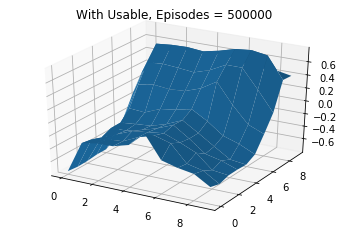

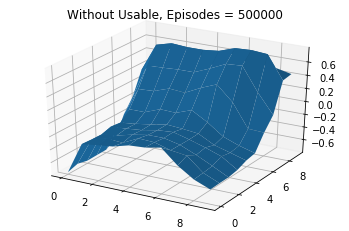

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


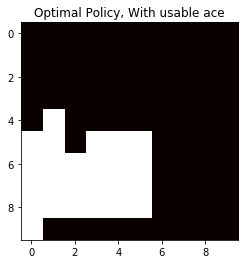

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 0. 0. 0. 0. 0.]]


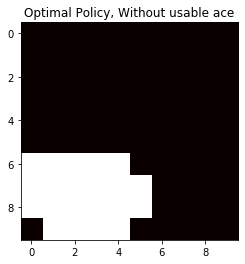

In [268]:
def plot_state_action_value(num_episode):
    
    q_sa, pol = monte_carlo_exploring_starts(num_episode)
    without_usable = np.zeros((10, 10))
    with_usable = np.zeros((10, 10))
    optimal_policy_without = pol[:, :, 0]
    optimal_policy_with = pol[:, :, 1]
    for i in range(10):
        for j in range(10):
            without_usable[i, j] = max(q_sa[i, j, 0, 0], q_sa[i, j, 0, 1])
            with_usable[i, j] = max(q_sa[i, j, 1, 0], q_sa[i, j, 1, 1])
            
    print (np.round(with_usable, 1))
    print (np.round(without_usable, 1))
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(0, 10, 1)
    X, Y = np.meshgrid(x, y)
    zs = np.array(fun(with_usable, X, Y))
    Z = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z)
    plt.title('With Usable, Episodes = ' + str(num_episode))
    plt.show()
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(0, 10, 1)
    X, Y = np.meshgrid(x, y)
    zs = np.array(fun(without_usable, X, Y))
    Z = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z)
    plt.title('Without Usable, Episodes = ' + str(num_episode))
    plt.show()
    
    print (optimal_policy_with)
    plt.imshow(optimal_policy_with, cmap='hot', interpolation='nearest')
    plt.title('Optimal Policy, With usable ace')
    plt.show()
    
    print (optimal_policy_without)
    plt.imshow(optimal_policy_without, cmap='hot', interpolation='nearest')
    plt.title('Optimal Policy, Without usable ace')
    plt.show()
    
plot_state_action_value(500000)

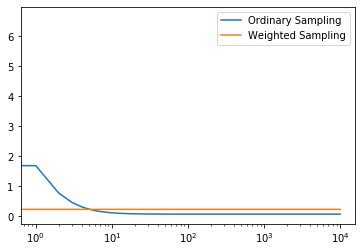

In [264]:
# target policy
def pi(player_sum):
    if (player_sum >= 20):
        return 'stick'
    else:
        return 'hit'

ordinary_error = np.zeros((runs, num_episodes))
weighted_error = np.zeros((runs, num_episodes))
actual = -0.27726

def mc_off_policy(num_episodes):
    G_values = np.zeros(num_episodes)
    # the policy ratios are the rhos that when multiplied with return for b gives one for pi
    policy_ratios = np.zeros(num_episodes)
    
    for i in range(num_episodes):
        
        # given initial state
        game = Black_Jack_Game(exploring_starts=False)
        game.current_player_sum = 13
        game.dealer_visible_card = 2
        game.holds_usable_ace = True
        
        collection, reward = play_Black_Jack(game, behavioural=True)
        ratio = 1
        
        for j in range(len(collection)-1, -1, -1):
            St, At = collection[j]
            
            # chosen action is same as that in target
            if(At != pi(St[0])):
                ratio = 0.0
                break
            else:
                ratio *= 2.0
                
        policy_ratios[i] = ratio
        G_values[i] = reward
        return np.add.accumulate(policy_ratios * G_values), np.add.accumulate(policy_ratios)

def plot_off_policy(runs):
    for i in range(runs):
        g_weighted, ratios_weighted = mc_off_policy(10000)
        
        ordinary_sampling = g_weighted / np.arange(1, num_episodes + 1)
        weighted_sampling = np.zeros_like(g_weighted)

        for j in range(num_episodes):
            # avoid zero division 
            if(ratios_weighted[j]!=0):
                weighted_sampling[j] = g_weighted[j] / ratios_weighted[j]

        ordinary_error[i] = (ordinary_sampling - actual)**2
        weighted_error[i] = (weighted_sampling - actual)**2

    plt.plot(np.mean(ordinary_sampling_err, axis=0), label='Ordinary Sampling')
    plt.plot(np.mean(weighted_sampling_err, axis=0), label='Weighted Sampling')
    plt.xscale('log')
    plt.legend()
    plt.show()
    plt.close()
    
plot_off_policy(100)